# The orthogonal Procrustes problem

Originally, this problem questioned ways of finding orthogonal transformation between two matrices. Maybe that doesn't sound relevant to real computer vision applications, but that feeling may change when you consider the fact that a set of points is indeed a matrix. Camera calibration, rigid body transformations, photogrammetry issues, and many other tasks require solving of the orthogonal Procrustes problem. In this recipe, we find a solution to the simple task of estimation point set rotation and examine how our solution is influenced by noisy input data.

To find a solution to the orthogonal Procrustes problem, we applied SVD to the multiplication product of two matrices: the matrix composed of initial points and another one composed of points after rotation. The rows in each matrix are ($x, y$) coordinates of corresponding points. The **SVD** approach is well-known and gives stability to noise outcomes. `cv2.SVDecomp` is a function that implements **SVD** in OpenCV. It accepts a matrix ($M\times N$) to decompose and returns three matrices. The first returned matrix is a rectangular diagonal matrix of size $M\times N$, with positive numbers on the diagonal called singular values. The second and third matrices are a left-singular vector matrix and a conjugated transpose of a right-singular vector matrix, respectively.

SVD is an extremely handy tool in linear algebra. It is used a lot in many different tasks because it's able to produce robust solutions. We're not digging deep into the theory of SVD, because it's a separate and indeed vast topic. However, we'll understand this procedure later in other recipes of this chapter.

Let's also review another of OpenCV's functions from the preceding code. The `cv2.getRotationMatrix2D` function hasn't been mentioned previously in this book. It computes a matrix of affine transformation for a given center and angle of rotation and scale. The arguments follow in this order: center of rotation (in ($x,y$) format), angle of rotation (in degrees), scale. The returned value is a $2\times3$ matrix of affine transformation.

`cv2.invert` finds a pseudo-inverse matrix for a given one matrix. This function accepts a matrix to invert, and optionally a matrix to save the result and inversion method flag. By default, the flag is set to `cv2.DECOMP_LU`, which applies the **LU** decomposition to find the result. Also, `cv2.DECOMP_SVD` and `cv2.DECOMP_CHOLESKY` are available as options; the first uses SVD to find a pseudo-inverse matrix (yes, another application of SVD), and the second one applies Cholesky decomposition for the same purpose. The function returns two objects, a `float` value and the resulting inverted matrix. If the first returned value is `0`, the input matrix is singular. In this case, `cv2.DECOMP_LU` and `cv2.DECOMP_CHOLESKY` can't produce the result, but `cv2.DECOMP_SVD` computes the pseudo-inverse matrix.

As you can see, despite the fact that the difference between points before and after adding noise is relatively large, the difference between the initial and estimated points and the rotation matrices is slight.

*If you're interested in the theory of the SVD, this Wikipedia page is a good place to start: https://en.wikipedia.org/wiki/Singul ar-value_decomposition.*

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2,start_3=0, end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S06\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s06\env

d:\html_doc\program\opencv\packt\s06\env\lib\site-packages
d:\html_doc\program\opencv\packt\s06\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s06\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s06\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s06\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s06\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S06\env


Generate an initial points set. Then create a set of rotated points by applying a rotation matrix to the initial points. Also, add a portion of noise to our rotated points:

------  pts----------------------    Shape(50, 2) pts: float64
[ 138.446882421075 284.0224247835971 ]
[ 107.68225100994503 306.41920641500184 ]
[ 160.2352399797394 302.7428573573656 ]
[ 93.95661501479029 268.5145263476834 ]
[ 154.32949513128915 321.69141652604003 ]


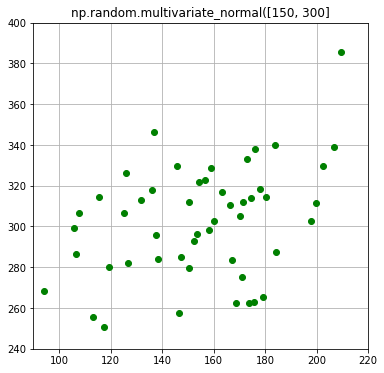

In [2]:
np.random.seed(42)
pts = np.random.multivariate_normal([150, 300], [[1024, 512], [512, 1024]], 50)

#######################################
print_image('pts','pts',pts,0,5,0,4)

plt.figure(figsize=(6,6))
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('np.random.multivariate_normal([150, 300]')
plt.plot(pts[:,0],pts[:,1],'o', color="green")
plt.show()

------  rmat---------------------    Shape(2, 2) rmat: float64
[ 0.8660254037844387 0.49999999999999994 ]
[ -0.49999999999999994 0.8660254037844387 ]


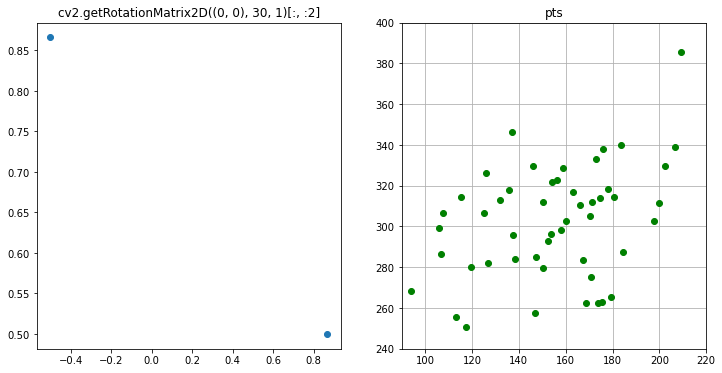

In [3]:
rmat = cv2.getRotationMatrix2D((0, 0), 30, 1)[:, :2]


#############################################
print_image('rmat','rmat',rmat,0,5,0,4)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.axis('on')
plt.title('cv2.getRotationMatrix2D((0, 0), 30, 1)[:, :2]')
plt.plot(rmat[:,0],rmat[:,1],'o')

plt.subplot(122)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o', color="green")
plt.show()

------  pts----------------------    Shape(50, 2) pts: float64
[ 138.446882421075 284.0224247835971 ]
[ 107.68225100994503 306.41920641500184 ]
[ 160.2352399797394 302.7428573573656 ]
[ 93.95661501479029 268.5145263476834 ]
[ 154.32949513128915 321.69141652604003 ]
------  rmat---------------------    Shape(2, 2) rmat: float64
[ 0.8660254037844387 0.49999999999999994 ]
[ -0.49999999999999994 0.8660254037844387 ]
------  rpts---------------------    Shape(50, 2) rpts: float64
[ 261.90972964320673 176.74719389651256 ]
[ 246.46516811880582 211.52569145788672 ]
[ 290.139217082633 182.0653852958976 ]
[ 215.62607863024448 185.56209359484467 ]
[ 294.4989715999433 201.42819132530732 ]


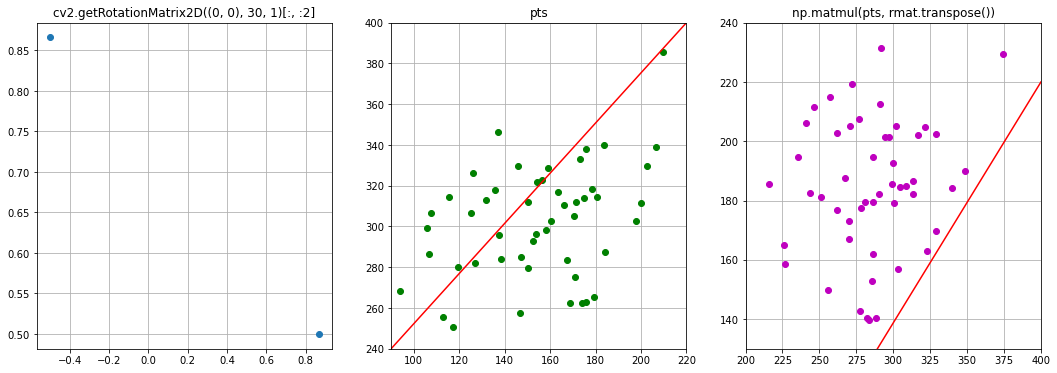

In [4]:
rpts = np.matmul(pts, rmat.transpose())


#############################################
print_image('pts','pts',pts,0,5,0,4)
print_image('rmat','rmat',rmat,0,5,0,4)
print_image('rpts','rpts',rpts,0,5,0,4)


plt.figure(figsize=(18,6))
plt.subplot(131)
plt.axis('on'); plt.grid();
plt.title('cv2.getRotationMatrix2D((0, 0), 30, 1)[:, :2]')
plt.plot(rmat[:,0],rmat[:,1],'o')

plt.subplot(132)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o',color="green")
plt.plot([90,220], [240,400], color='red')

plt.subplot(133)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(130, 240);
plt.title('np.matmul(pts, rmat.transpose())')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.plot([240,400], [90,220], color='red')
plt.show()

------  pts----------------------    Shape(50, 2) pts: float64
[ 138.446882421075 284.0224247835971 ]
[ 107.68225100994503 306.41920641500184 ]
[ 160.2352399797394 302.7428573573656 ]
[ 93.95661501479029 268.5145263476834 ]
[ 154.32949513128915 321.69141652604003 ]
------  rmat---------------------    Shape(2, 2) rmat: float64
[ 0.8660254037844387 0.49999999999999994 ]
[ -0.49999999999999994 0.8660254037844387 ]
------  rpts---------------------    Shape(50, 2) rpts: float64
[ 261.90972964320673 176.74719389651256 ]
[ 246.46516811880582 211.52569145788672 ]
[ 290.139217082633 182.0653852958976 ]
[ 215.62607863024448 185.56209359484467 ]
[ 294.4989715999433 201.42819132530732 ]
------  rpts_noise---------------    Shape(50, 2) rpts_noise: float64
[ 268.93432856131824 174.79184139742927 ]
[ 255.62486726656184 233.0645862462005 ]
[ 286.82778830054133 178.75418869619466 ]
[ 237.959520445884 196.41525961688635 ]
[ 287.85960116218337 209.10114904571742 ]


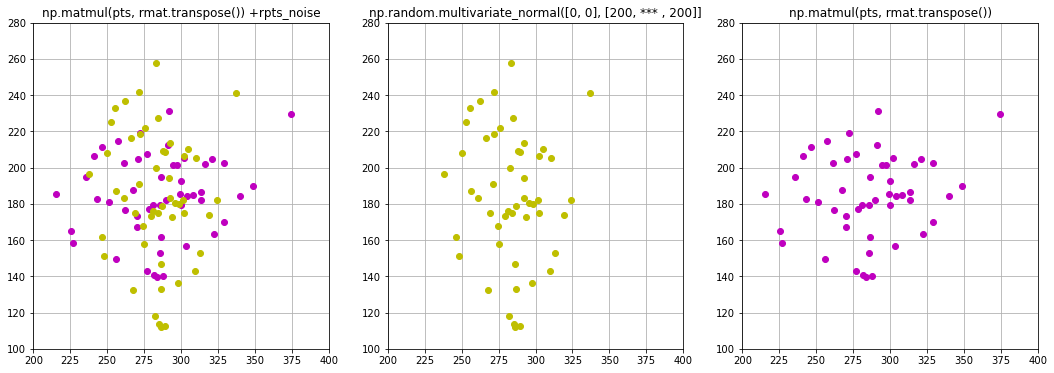

In [5]:
np.random.seed(42)
rpts_noise = rpts + np.random.multivariate_normal([0, 0], [[200, 0], [0, 200]], len(pts))



#############################################
print_image('pts','pts',pts,0,5,0,4)
print_image('rmat','rmat',rmat,0,5,0,4)
print_image('rpts','rpts',rpts,0,5,0,4)
print_image('rpts_noise','rpts_noise',rpts_noise,0,5,0,4)

plt.figure(figsize=(18,6))

plt.subplot(131)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(100, 280);
plt.title('np.matmul(pts, rmat.transpose()) +rpts_noise')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'o',color="y")

plt.subplot(132)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(100, 280);
plt.title('np.random.multivariate_normal([0, 0], [200, *** , 200]]')
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'o',color="y")

plt.subplot(133)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(100, 280);
plt.title('np.matmul(pts, rmat.transpose())')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.show()

Solve the orthogonal Procrustes problem using **Singular Value Decomposition (SVD)** and get an estimate of the rotation matrix:

------  M------------------------    Shape(2, 2) M: float64
[ 2223978.8269045725 1402915.3787384506 ]
[ 4307733.569786189 2812796.7370990063 ]
------  rmat---------------------    Shape(2, 2) rmat: float64
[ 0.8660254037844387 0.49999999999999994 ]
[ -0.49999999999999994 0.8660254037844387 ]
------  rmat_est-----------------    Shape(2, 2) rmat_est: float64
[ 0.86626105343858 0.49959162052168354 ]
[ -0.49959162052168354 0.86626105343858 ]


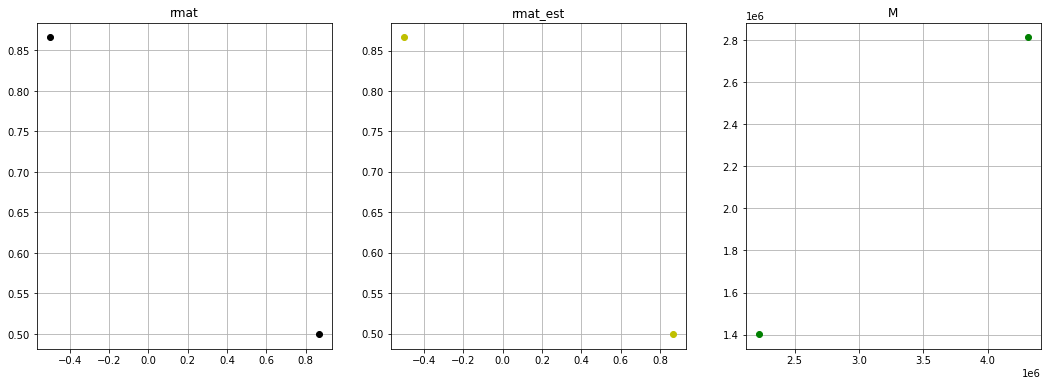

In [6]:
M = np.matmul(pts.transpose(), rpts_noise)

sigma, u, v_t = cv2.SVDecomp(M)

rmat_est = np.matmul(v_t, u).transpose()


#############################################
print_image('M','M',M,0,5,0,4)
print_image('rmat','rmat',rmat,0,5,0,4)
print_image('rmat_est','rmat_est',rmat_est,0,5,0,4)

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.axis('on'); plt.grid();
plt.title('rmat')
plt.plot(rmat[:,0],rmat[:,1],'o', color ="k")

plt.subplot(132)
plt.grid(); 
plt.title('rmat_est');
plt.plot(rmat_est[:,0],rmat_est[:,1],'o', color="y")

plt.subplot(133)
plt.axis('on'); plt.grid();
plt.title('M')
plt.plot(M[:,0],M[:,1],'o',color="green")

plt.show()

 Now we can use the estimated rotation matrix to find out how good our estimation is. To do so, compute the inverted rotation matrix and multiply our previously rotated points by this matrix. Then, calculate the Euclidean distances ($L2$) between rotated points with and without noise, between rotated back points and initial ones, and also between the original rotation matrix and its estimate:

------  rmat---------------------    Shape(2, 2) rmat: float64
[ 0.8660254037844387 0.49999999999999994 ]
[ -0.49999999999999994 0.8660254037844387 ]
------  rmat_est-----------------    Shape(2, 2) rmat_est: float64
[ 0.86626105343858 0.49959162052168354 ]
[ -0.49959162052168354 0.86626105343858 ]
------  rmat_inv-----------------    Shape(2, 2) rmat_inv: float64
[ 0.8662610534385797 -0.49959162052168343 ]
[ 0.49959162052168343 0.8662610534385797 ]
res 1.0


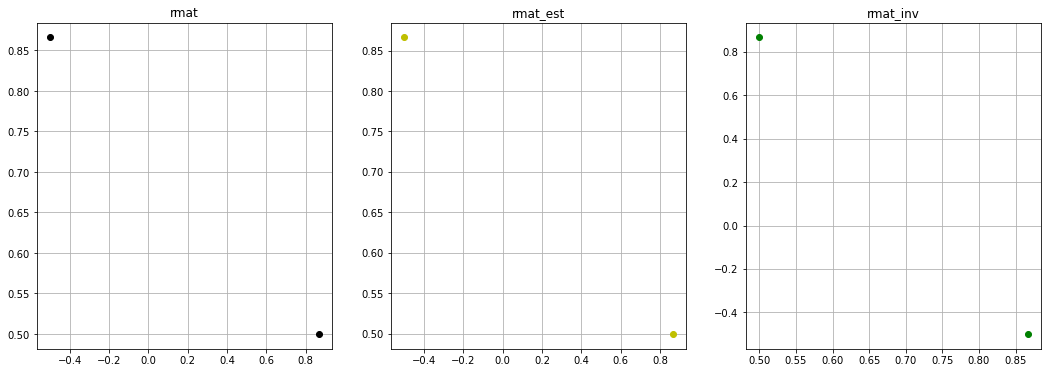

In [7]:
res, rmat_inv = cv2.invert(rmat_est)
assert res != 0


#############################################
print_image('rmat','rmat',rmat,0,5,0,4)
print_image('rmat_est','rmat_est',rmat_est,0,5,0,4)
print_image('rmat_inv','rmat_inv',rmat_inv,0,5,0,4)
print('res',res)

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.axis('on'); plt.grid();
plt.title('rmat')
plt.plot(rmat[:,0],rmat[:,1],'o', color ="k")

plt.subplot(132)
plt.axis('on'); plt.grid();
plt.title('rmat_est')
plt.plot(rmat_est[:,0],rmat_est[:,1],'o', color="y")

plt.subplot(133)
plt.axis('on'); plt.grid();
plt.title('rmat_inv')
plt.plot(rmat_inv[:,0],rmat_inv[:,1],'o',color="green")
plt.show()

------  pts----------------------    Shape(50, 2) pts: float64
[ 138.446882421075 284.0224247835971 ]
[ 107.68225100994503 306.41920641500184 ]
[ 160.2352399797394 302.7428573573656 ]
[ 93.95661501479029 268.5145263476834 ]
[ 154.32949513128915 321.69141652604003 ]
------  pts_est------------------    Shape(50, 2) pts_est: float64
[ 138.58078128511897 283.9571166399515 ]
[ 107.82671319309816 306.3684010542563 ]
[ 160.37796295296428 302.6672741003303 ]
[ 94.08320697662087 268.4701967253582 ]
[ 154.48115285178326 321.6186156732734 ]


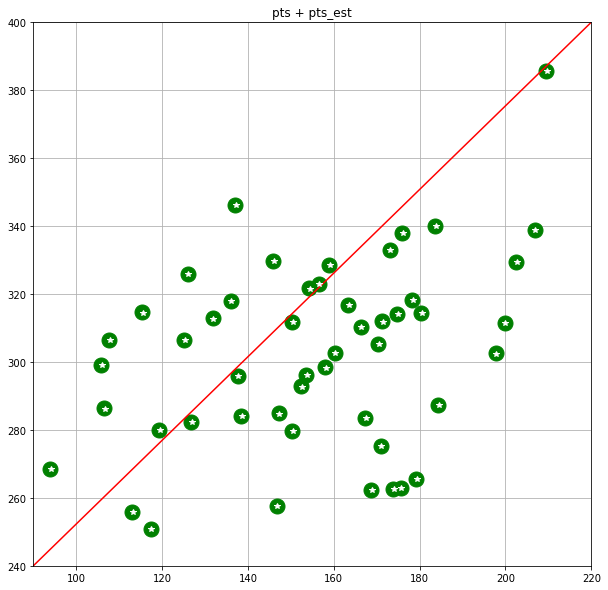

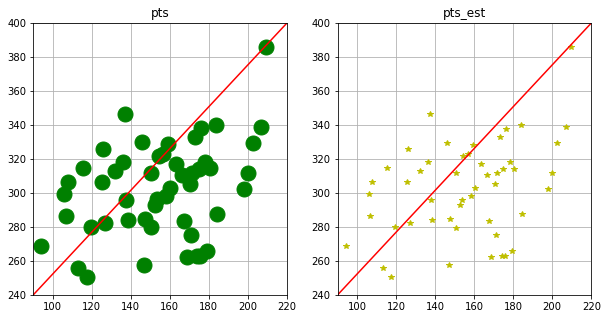

In [8]:
pts_est = np.matmul(rpts, rmat_inv.transpose())



###############################################
print_image('pts','pts',pts,0,5,0,4)
print_image('pts_est','pts_est',pts_est,0,5,0,4)


plt.figure(figsize=(10,10))
plt.subplot(111)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts + pts_est')
plt.plot(pts[:,0],pts[:,1],'o',color="green", markersize=15)
plt.plot([90,220], [240,400], color='red')
plt.plot(pts_est[:,0],pts_est[:,1],'*', color="w")
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o',color="green", markersize=15)
plt.plot([90,220], [240,400], color='red')

plt.subplot(122)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts_est')
plt.plot(pts_est[:,0],pts_est[:,1],'*', color="y")
plt.plot([90,220], [240,400], color='red')
plt.show()

------  pts----------------------    Shape(50, 2) pts: float64
[ 138.446882421075 284.0224247835971 ]
[ 107.68225100994503 306.41920641500184 ]
[ 160.2352399797394 302.7428573573656 ]
[ 93.95661501479029 268.5145263476834 ]
[ 154.32949513128915 321.69141652604003 ]
------  pts_est------------------    Shape(50, 2) pts_est: float64
[ 138.58078128511897 283.9571166399515 ]
[ 107.82671319309816 306.3684010542563 ]
[ 160.37796295296428 302.6672741003303 ]
[ 94.08320697662087 268.4701967253582 ]
[ 154.48115285178326 321.6186156732734 ]
------  rpts---------------------    Shape(50, 2) rpts: float64
[ 261.90972964320673 176.74719389651256 ]
[ 246.46516811880582 211.52569145788672 ]
[ 290.139217082633 182.0653852958976 ]
[ 215.62607863024448 185.56209359484467 ]
[ 294.4989715999433 201.42819132530732 ]
------  rpts_noise---------------    Shape(50, 2) rpts_noise: float64
[ 268.93432856131824 174.79184139742927 ]
[ 255.62486726656184 233.0645862462005 ]
[ 286.82778830054133 178.75418869619466 

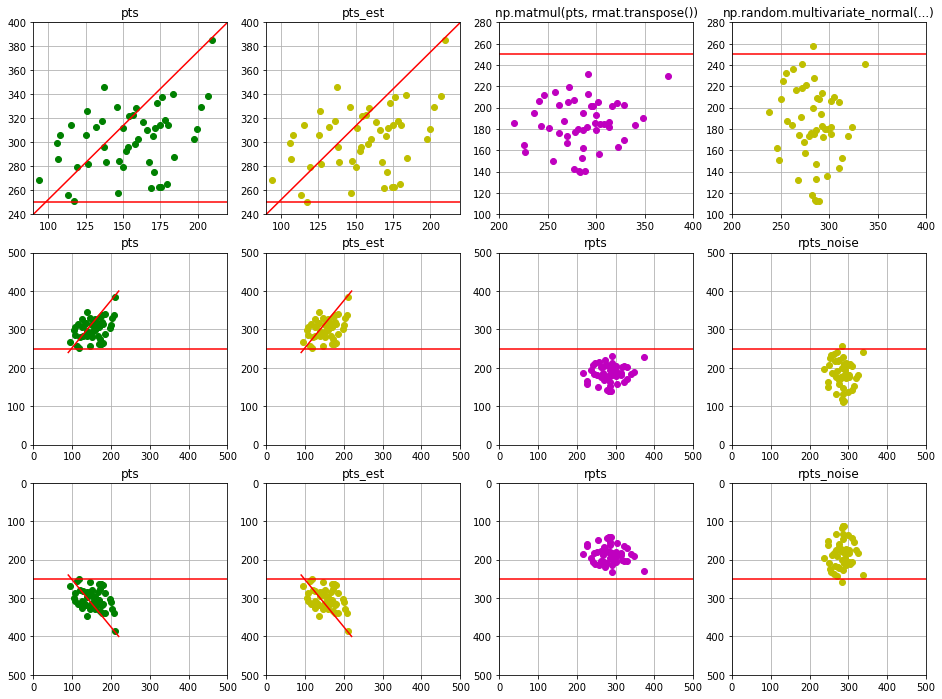

In [9]:
print_image('pts','pts',pts,0,5,0,4)
print_image('pts_est','pts_est',pts_est,0,5,0,4)
print_image('rpts','rpts',rpts,0,5,0,4)
print_image('rpts_noise','rpts_noise',rpts_noise,0,5,0,4)


plt.figure(figsize=(16,12))
plt.subplot(341)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o',color="green")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')

plt.subplot(342)
plt.axis('on'); plt.grid(); plt.ylim(240, 400); plt.xlim(90, 220);
plt.title('pts_est')
plt.plot(pts_est[:,0],pts_est[:,1],'o', color="y")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')

plt.subplot(343)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(100, 280);
plt.title('np.matmul(pts, rmat.transpose())')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.plot([0,500], [250,250], color='red')

plt.subplot(344)
plt.axis('on'); plt.grid(); plt.xlim(200, 400); plt.ylim(100, 280);
plt.title('np.random.multivariate_normal(...)')
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'o',color="y")
plt.plot([0,500], [250,250], color='red')

plt.subplot(345)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o',color="green")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')

plt.subplot(346)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('pts_est')
plt.plot(pts_est[:,0],pts_est[:,1],'o', color="y")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')

plt.subplot(347)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('rpts')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.plot([0,500], [250,250], color='red')

plt.subplot(348)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('rpts_noise')
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'o',color="y")
plt.plot([0,500], [250,250], color='red')

plt.subplot(349)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('pts')
plt.plot(pts[:,0],pts[:,1],'o',color="green")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')
plt.gca().invert_yaxis()

plt.subplot(3,4,10)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('pts_est')
plt.plot(pts_est[:,0],pts_est[:,1],'o', color="y")
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')
plt.gca().invert_yaxis()

plt.subplot(3,4,11)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('rpts')
plt.plot(rpts[:,0],rpts[:,1],'o', color="m")
plt.plot([0,500], [250,250], color='red')
plt.gca().invert_yaxis()

plt.subplot(3,4,12)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('rpts_noise')
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'o',color="y")
plt.plot([0,500], [250,250], color='red')
plt.gca().invert_yaxis()

plt.show()

In [10]:
rpts_err = cv2.norm(rpts, rpts_noise, cv2.NORM_L2)
pts_err = cv2.norm(pts_est, pts, cv2.NORM_L2)
rmat_err = cv2.norm(rmat, rmat_est, cv2.NORM_L2)


###############################################
print("rpts_err = ", rpts_err)
print("pts_err = ",pts_err)
print("rmat_err =",rmat_err)

rpts_err =  128.6317452162366
pts_err =  1.1408887381592496
rmat_err = 0.0006667901586059355


Display our data, showing initial points as green-filled circles, rotated points as yellow-filled circles, rotated back points as thin white circles, and rotated points with noise as thin red circles. Then, print the information about $L2$ differences between the points and matrices and show the resulting image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


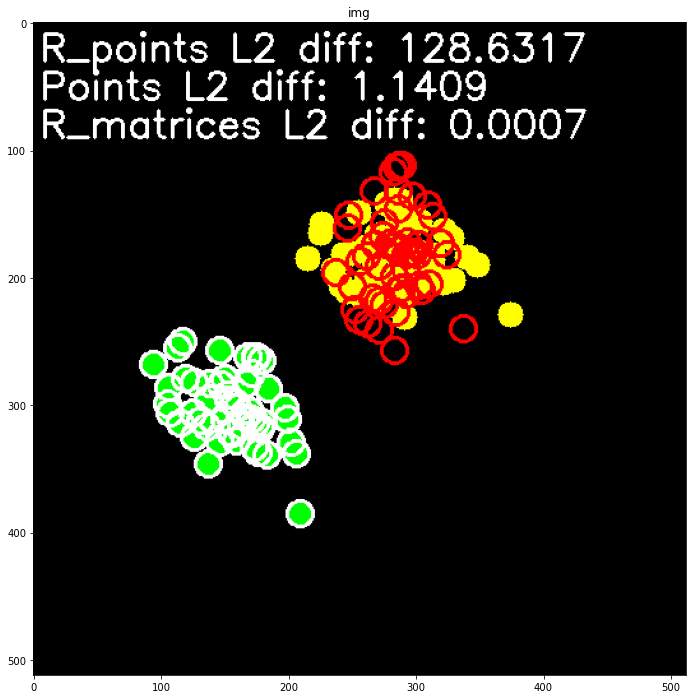

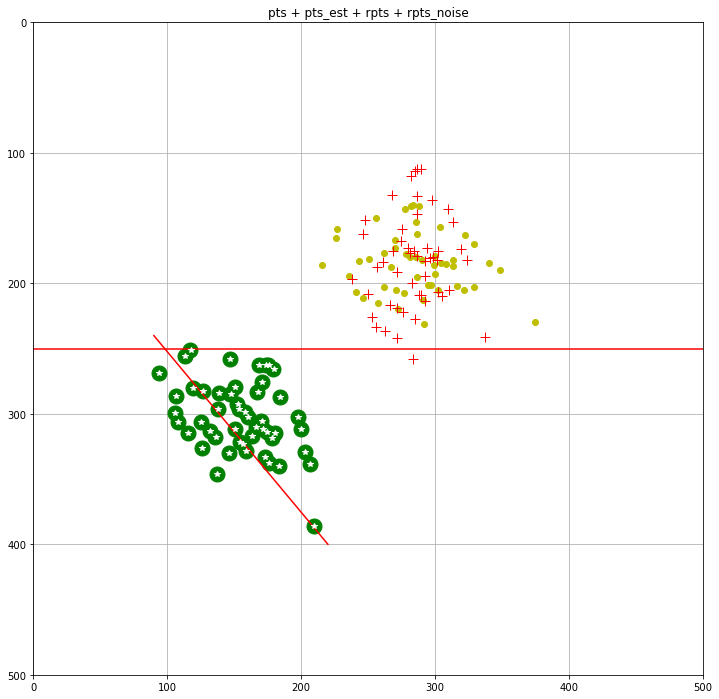

In [11]:
def draw_pts(image, points, color, thickness=cv2.FILLED):
    for pt in points:
        cv2.circle(img, tuple([int(x) for x in pt]), 10, color, thickness)

img = np.zeros([512, 512, 3])

draw_pts(img, pts, (0, 255, 0))
draw_pts(img, pts_est, (255, 255, 255), 2)
draw_pts(img, rpts, (0, 255, 255))
draw_pts(img, rpts_noise, (0, 0, 255), 2)

cv2.putText(img, 'R_points L2 diff: %.4f' % rpts_err, (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img, 'Points L2 diff: %.4f' % pts_err, (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img, 'R_matrices L2 diff: %.4f' % rmat_err, (5, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


####################################################
plt_view_image(plt,[["img",img[:,:,[2,1,0]]]],
               figsize=(12,12),axis='on',cmap='gray')

plt.figure(figsize=(12,12))
plt.subplot(111)
plt.axis('on'); plt.grid(); plt.ylim(0, 500); plt.xlim(0, 500);
plt.title('pts + pts_est + rpts + rpts_noise')
plt.plot(pts[:,0],pts[:,1],'o',color="green",markersize=15)
plt.plot([90,220], [240,400], color='red')
plt.plot([0,500], [250,250], color='red')
plt.plot(pts_est[:,0],pts_est[:,1],'*', color="w")
plt.plot(rpts[:,0],rpts[:,1],'o', color="y")
plt.plot(rpts_noise[:,0],rpts_noise[:,1],'+',color="r",markersize=10)
plt.gca().invert_yaxis()
plt.show()

cv2.imshow('Points', img)
cv2.waitKey()
cv2.destroyAllWindows()